# **Прогноз цен на недвижимость**

Задача заключается в том, чтобы спрогнозировать стоимость квартир. Показателем оценки является R2 коэффициент детерминации (sklearn.metrics.r2_score), необходимо получить $R^2 > 0.6$.

# Загрузка и подготовка данных

Импортируем необходимые библиотеки.

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [ ]:
!pip install shap

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import warnings
from catboost import CatBoostRegressor
from datetime import datetime
from scipy import stats
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, GammaRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
warnings.filterwarnings("ignore")
%matplotlib inline

Создадим функцию для оценки результата.

In [ ]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))

    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')

    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Загрузим данные.

In [ ]:
df = pd.read_csv("train.csv")
df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945


**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры - целевой признак.

Выведем информацию о признаках.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Видим, что датасет  содержит 10000 объектов 19 столбцов. Есть пропуски в столбцах 'LifeSquare' и 'Healthcare_1'. Есть категориальные и числовые признаки.Удалим столбец 'Id', так как он не несет полезной информации для обучения.

In [ ]:
df.drop('Id', axis=1, inplace=True)

## Описательная статистика

Выведем описательную статистику для числовых и категориальных столбцов.

In [ ]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [ ]:
df.describe(include=object)

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


Построим матрицу корреляций, чтобы понять, есть ли связь между переменными.

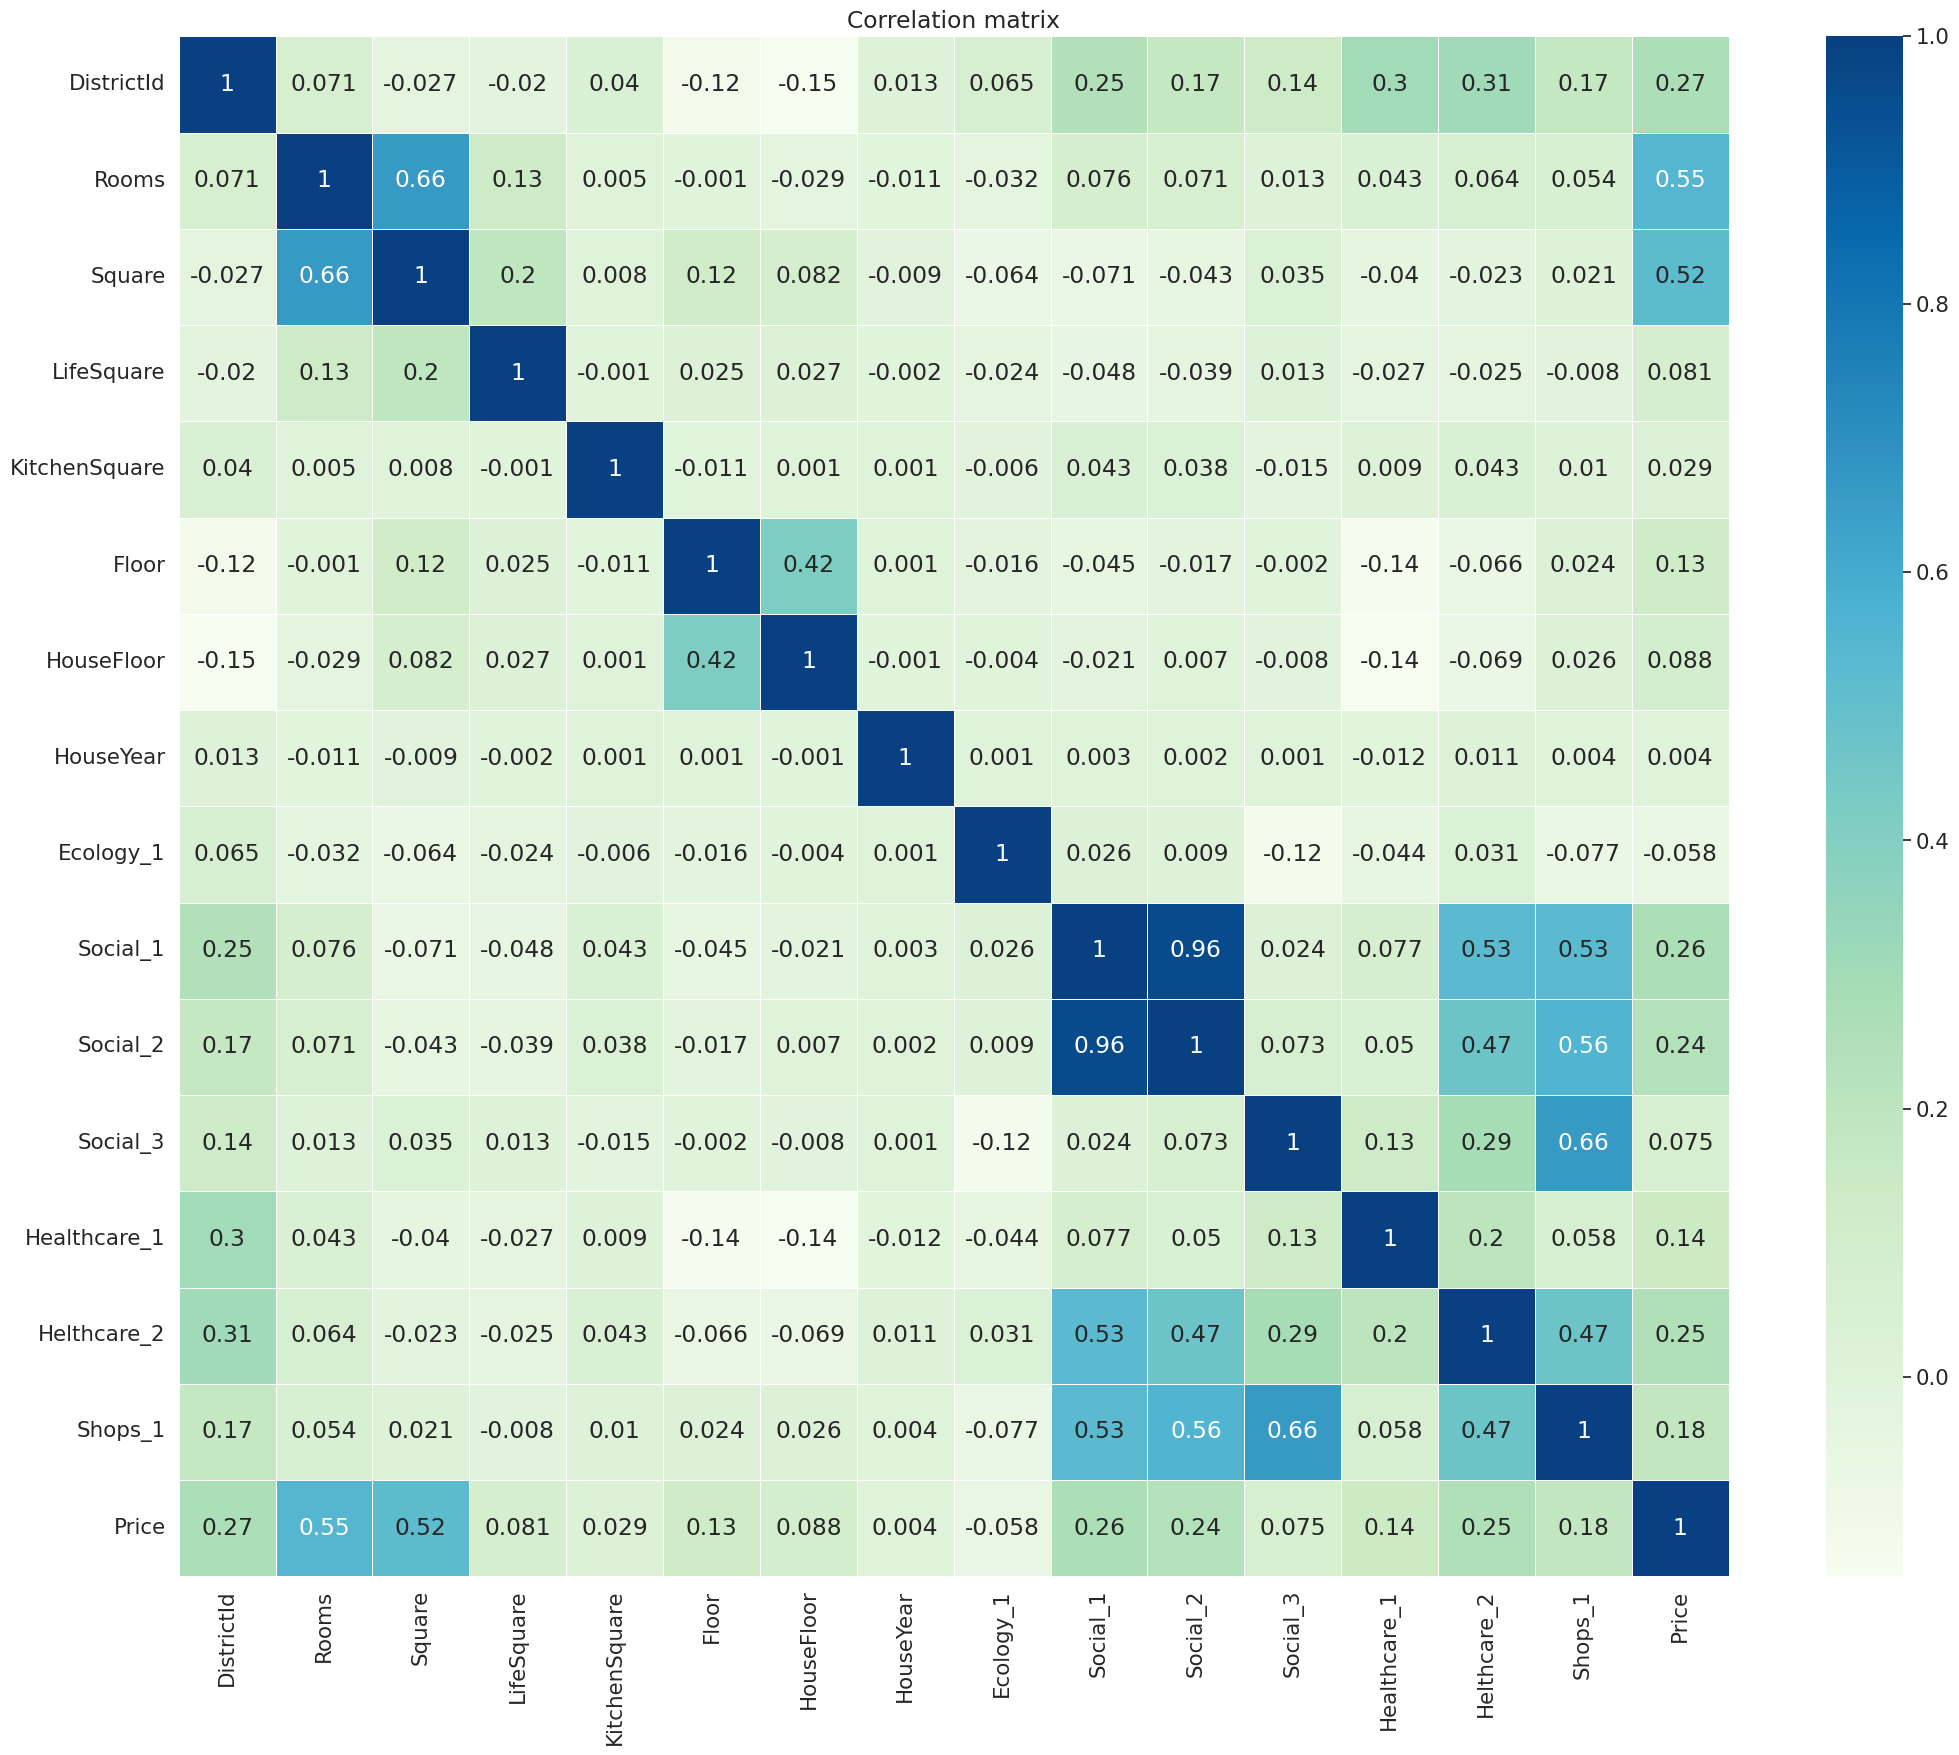

In [ ]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Видим, что с целевым признаком больше всего коррелируют количество комнат и площадь. Признаки 'Square' и 'Rooms' коррелируют друг с другом.
Самая низкая корреляция с признаком 'Ecology_1'.

Social_1 коррелирует с Helthcare_2 и Shops_1, Social_2 и Social_3 коррелирует с Shops_1.

## Проверка несоответствий в данных и обработка выбросов

Построим ящики с усами, чтобы визуализировать распределения числовых данных.

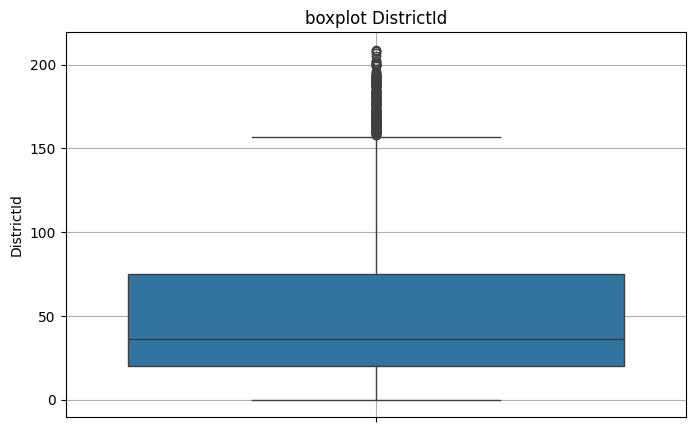

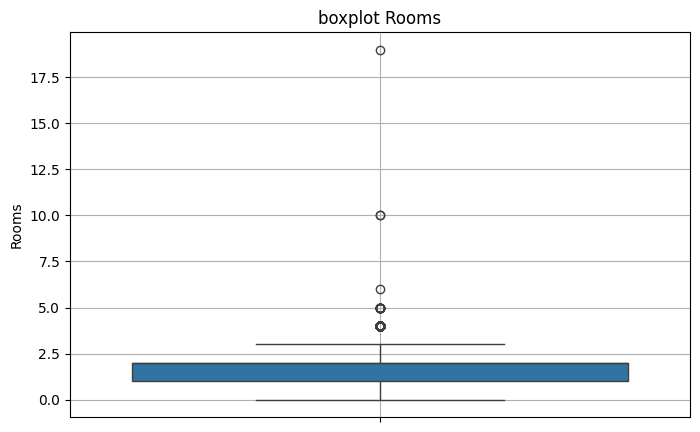

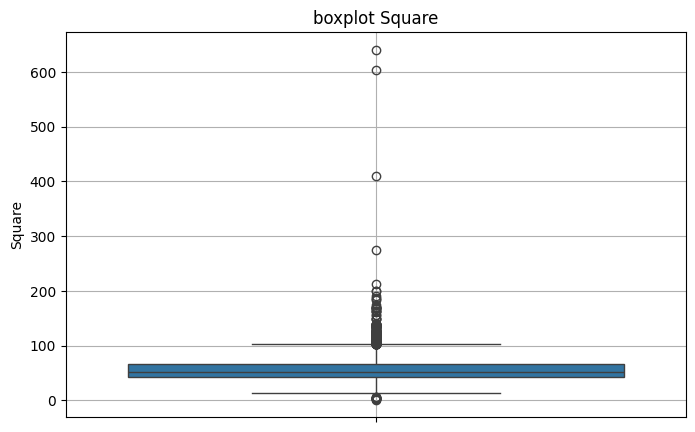

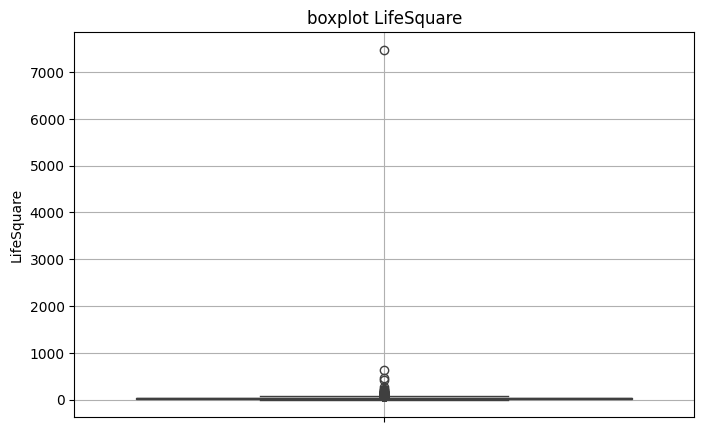

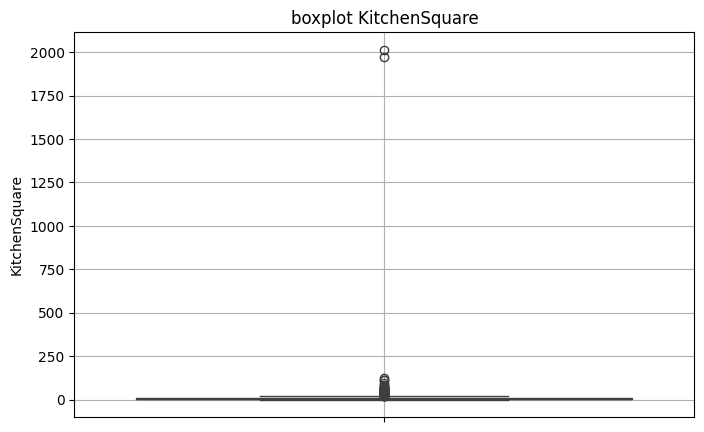

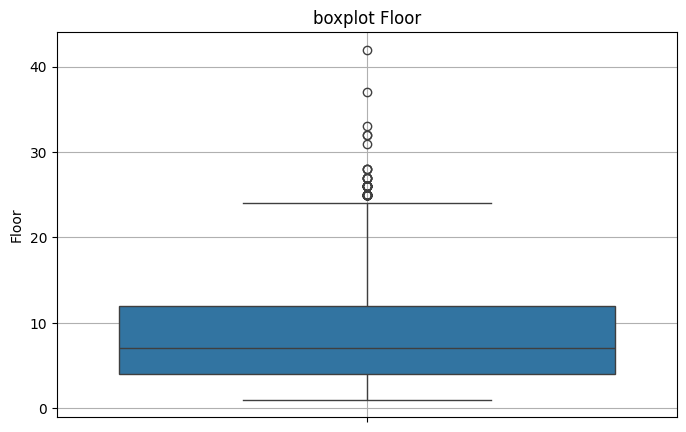

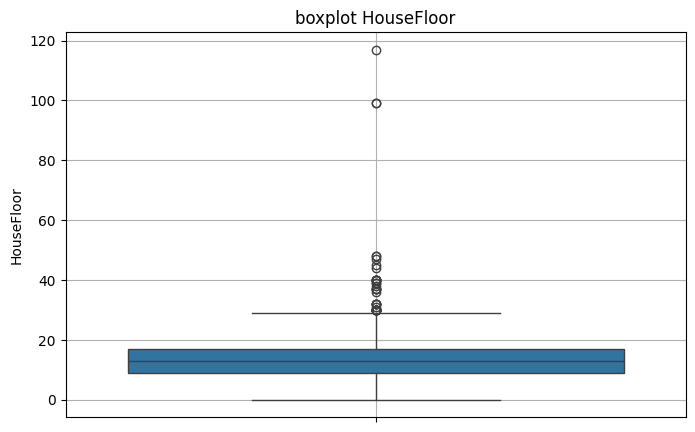

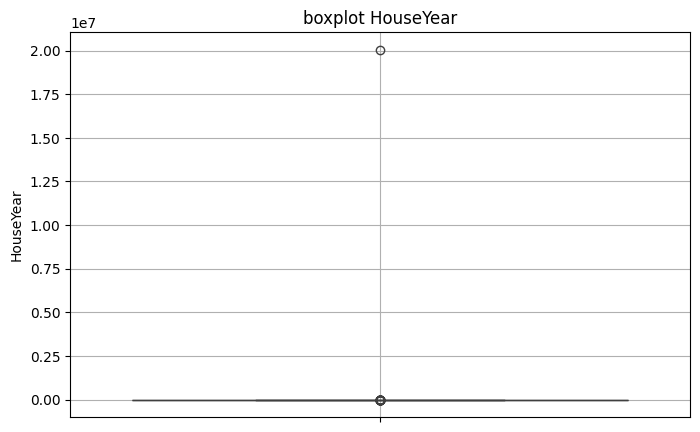

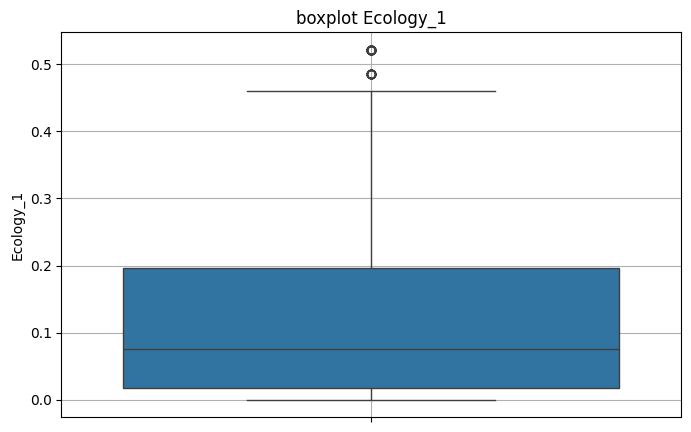

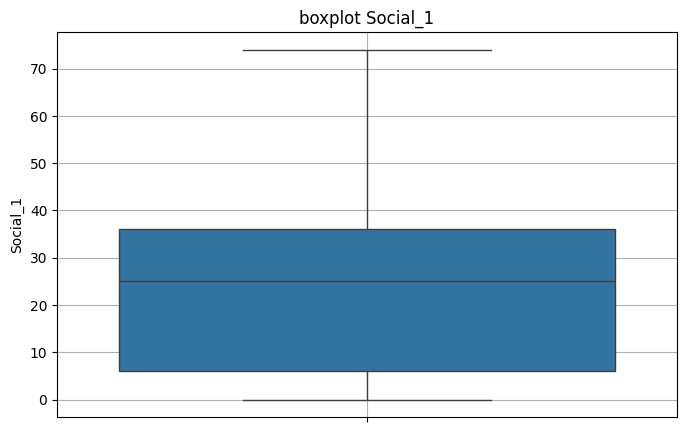

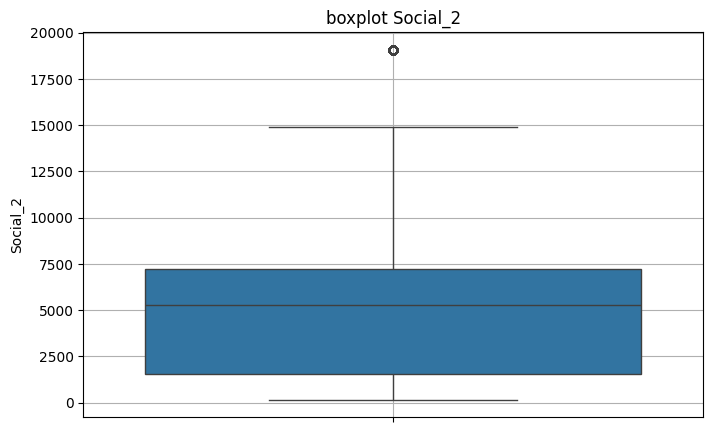

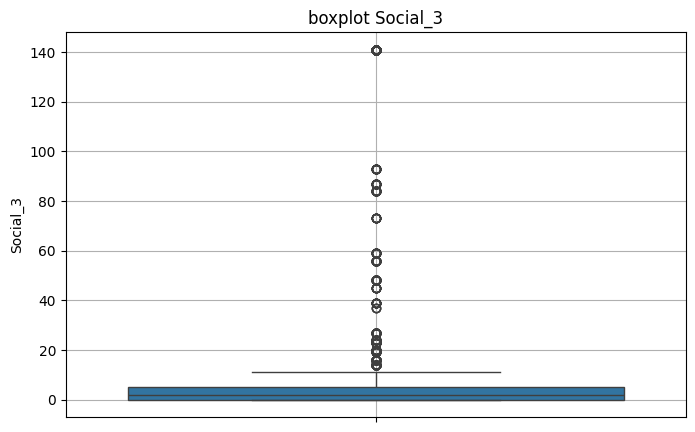

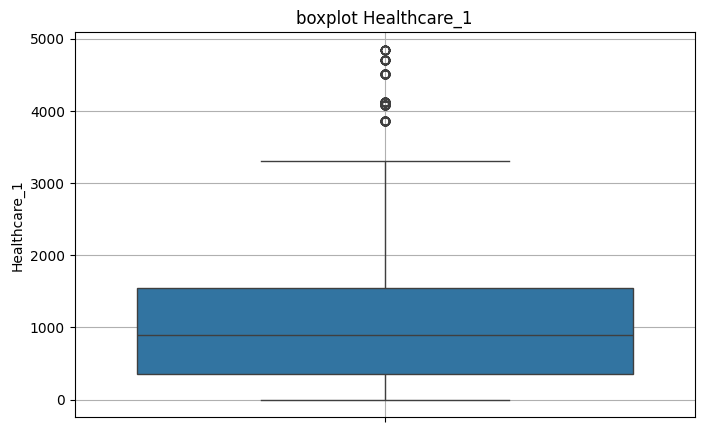

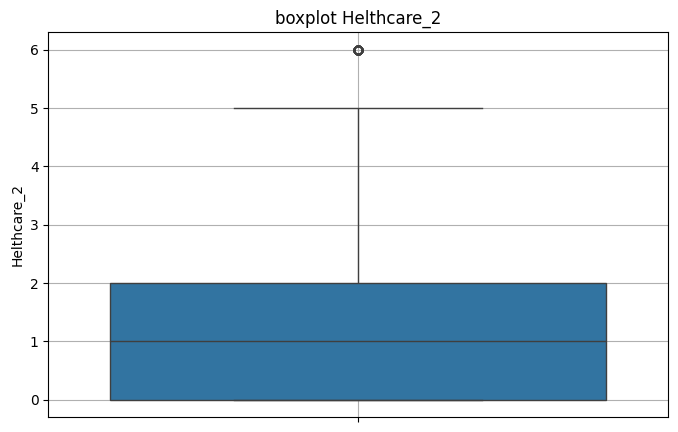

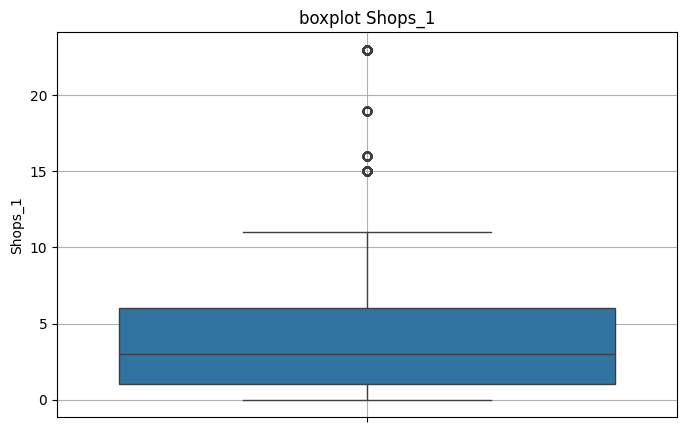

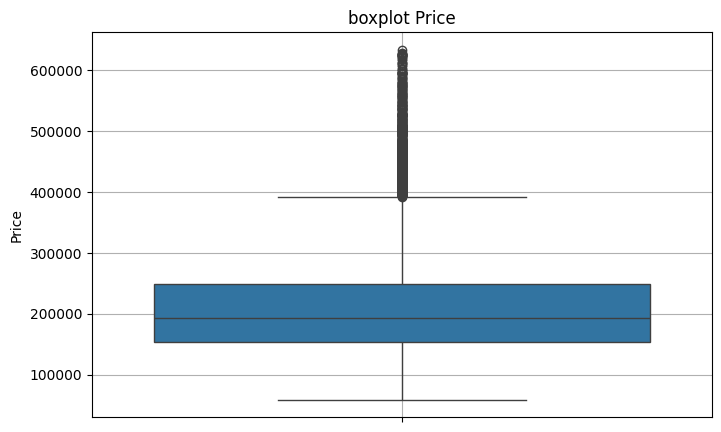

In [ ]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(df[col])
    plt.title(f'boxplot {col}')
    # plt.xlabel(col)
    plt.grid(True)
    plt.show()

Выбросы по признакам:

- DistrictId: значения больше 150.Однако, удалять их не планируется, так как признак в также можно отнести к категориальному.
- Rooms: значения больше 3.
- Square: несколько минимальных значений около 0 и значения больше 100.
- LifeSquare: дисперсия данных очень маленькая, значительная часть значений обозначена как выбросы.Построим ящик с усами позже при анализе признака.
- KitchenSquare: дисперсия данных очень маленькая, значительная часть значений обозначена как выбросы. Построим ящик с усами позже при анализе признака.
- Floor: 	значения больше 25.
- HouseFloor: значения больше 25.
- HouseYear: дисперсия данных очень маленькая, очень большое значение обозначено как выброс.
- Ecology_1: значение больше 0.45.
- Social_1: выбросов нет.
- Social_2: значение около 20 тыс.
- Social_3: значения больше 15.
- Healthcare_1: значение выше примерно 4 тыс.
- Helthcare_2: значения выше 5. Проверим этот признак, вероятно, он может являться категориальным.
- Shops_1: значения больше 10.
- Price: значения больше 400 тыс.

Некоторые столбцы явно содержат некорректные данные.

In [ ]:
df['Helthcare_2'].value_counts()

,count
Helthcare_2,
0,4214
1,2183
3,1670
2,1158
5,388
4,288
6,99


Скорее всего, признак 'Helthcare_2' – категориальный, так как содержит 7 уникальных значений, представленных целыми числами. Они могут характеризовать  количество, качество или доступность объектов здравоохранения. Преобразуем его.

In [ ]:
df['Helthcare_2'] = df['Helthcare_2'].astype('category')

Столбцы 'Ecology_1', 	'Social_1', 	'Social_2', 	'Social_3', 	'Healthcare_1', 	'Shops_1' оставим как есть, так как сложно сказать, что именно означают числа признаков.

Проверим признаки на логичность и согласованность.

### KitchenSquare

Построим диаграмму размаха с выбросами и без них, чтобы лучше понимать диапазон значений.

<Axes: ylabel='KitchenSquare'>

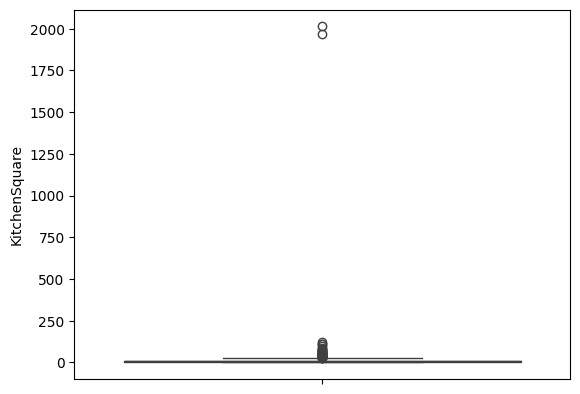

In [ ]:
sns.boxplot(df['KitchenSquare'], whis=2.0)

<Axes: ylabel='KitchenSquare'>

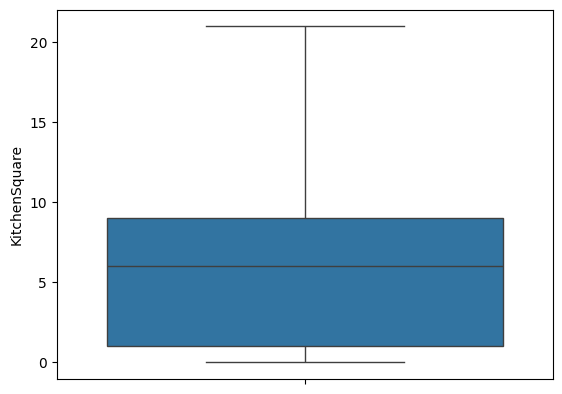

In [ ]:
sns.boxplot(df['KitchenSquare'], showfliers=False)

Значения чуть больше 20 считаются выбросами – и таких значение большое количество. Попробуем пока оставить данные как есть.

Проверим, нет ли ошибочных значений, когда площадь кухни больше общей площади.

In [ ]:
df.loc[df['KitchenSquare'] >= df['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2785,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960518
5273,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.033165
6505,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275
9520,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207


Таких значений 4, и они похожи на ошибки заполнения. Вероятно, десятичная точка слишком смещена вправо. Исправим это.

In [ ]:
ks = df.loc[(df['KitchenSquare'] >= df['Square']), 'KitchenSquare']

In [ ]:
new_ks = []
for k in ks:
  s = list(str(int(k)))
  s.insert(1, '.')
  n = ''.join(s)
  new_ks.append(int(float(n)))
  print(int(float(n)))

8
7
1
2


Заполним ошибочные значения новыми.

In [ ]:
df.loc[(df['KitchenSquare'] >= df['Square']), 'KitchenSquare'] = new_ks

### LifeSquare

Построим диаграмму размаха с выбросами и без них, чтобы лучше понимать диапазон значений.

<Axes: ylabel='LifeSquare'>

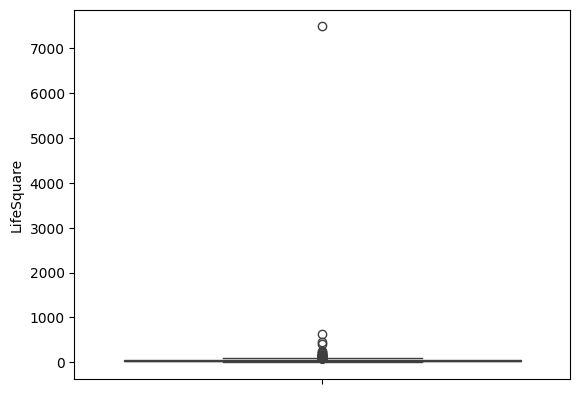

In [ ]:
sns.boxplot(df['LifeSquare'], whis=2.0)

<Axes: ylabel='LifeSquare'>

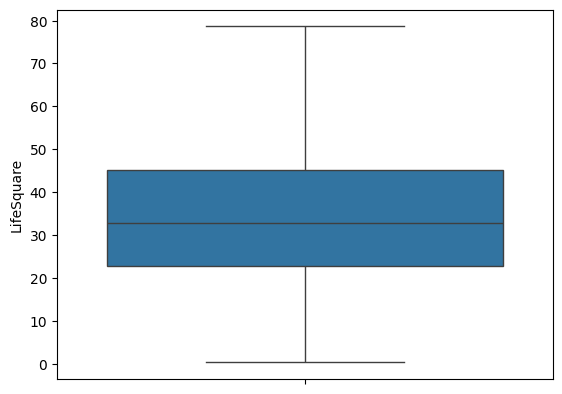

In [ ]:
sns.boxplot(df['LifeSquare'], showfliers=False)

Значения чуть около 100 считаются выбросами – и таких значение большое количество. Попробуем пока оставить данные как есть.

Проверим, нет ли ошибочных значений, когда жилая площадь больше общей площади.

In [ ]:
df.loc[df['LifeSquare'] > df['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
33,74,2.0,73.314975,74.131261,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863
64,1,3.0,87.200625,87.730225,0.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.365669
77,45,1.0,38.467276,39.624493,1.0,11,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.530601
100,74,2.0,79.937665,82.931595,1.0,8,21.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,226808.747168
111,20,1.0,28.438794,32.514021,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.114376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
9962,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617
9979,6,1.0,40.043234,41.984322,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598
9987,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698


Таких значений 482. Заполним жилую площадь в этих строках разностью между общей площадью и площадью кухни.

In [ ]:
df.loc[(df['LifeSquare'] > df['Square']), 'LifeSquare'] = df['Square'] - df['KitchenSquare'] - 2

Проверим работу.

In [ ]:
df.loc[df['LifeSquare'] > df['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


### Floor

Проверим, есть ли такие объекты, где этаж выше количества этажей в здании.

In [ ]:
df.loc[df['HouseFloor'] < df['Floor']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
17,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566
19,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777
21,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.246494
24,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
25,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,48,3.0,96.056784,95.056784,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
9968,1,3.0,86.487550,NaN,1.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,248248.935528
9970,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,114878.830713
9975,6,2.0,52.573133,NaN,1.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184


Таких строк довольно много: 1825 объектов имеют этаж выше, чем количество этажей в здании, что невозможно. Это критическая проблема. Попробуем понять, насколько обычно этаж квартиры превышает количество этажей.

In [ ]:
problem_floor = df.loc[df['HouseFloor'] < df['Floor']]

In [ ]:
problem_floor['Difference'] = problem_floor['Floor'] - problem_floor['HouseFloor']

Выведем самые частые проблемные комбинации.

In [ ]:
problem_floor[['Floor', 'HouseFloor']].value_counts().head(10)

,,count
Floor,HouseFloor,
6,5.0,163
10,9.0,121
18,17.0,93
7,5.0,76
13,12.0,72
11,9.0,63
19,17.0,50
4,1.0,46
5,1.0,42


Чаще всего видим разницу в 1-2 этажа. В большинстве случаев, скорее всего, перепутаны столбцы Floor и HouseFloor. Поменяем их местами.

In [ ]:
mask = df['HouseFloor'] < df['Floor']
df.loc[mask, ['Floor', 'HouseFloor']] = df.loc[mask, ['HouseFloor', 'Floor']].values

Проверим работу.

In [ ]:
df.loc[df['HouseFloor'] < df['Floor']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Больше строк, где этаж выше количества этажей в здании, нет.

### HouseYear

В описательной статистике в столбце года постройки дома было замечено, что максимально значение превышает 20 миллионов – это не корректно. Выведем числа, которые не могут являться годом постройки.

In [ ]:
df['HouseYear'].value_counts().sort_index(ascending=False)

,count
HouseYear,
20052011,1
4968,1
2020,19
2019,79
2018,175
...,...
1917,3
1916,1
1914,1


Видим, что таких чисел два. Заменим их максимальным корректным значением.

In [ ]:
df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020

### HouseFloor

В описательной статистике было замечено, что максимальное значение в признаке 'HouseFloor' = 117.  Это ошибочное значение. Выведем самые большие значения, чтобы оценить, насколько они правдоподобны.

In [ ]:
df['HouseFloor'].value_counts().sort_index(ascending=False)

,count
HouseFloor,
117.0,1
99.0,2
48.0,2
47.0,1
45.0,1
44.0,1
40.0,7
39.0,2
38.0,1


In [ ]:
df.loc[df['HouseFloor'] == 40]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
761,30,1.0,117.370746,102.187199,6.0,14,40.0,2011,0.000078,B,B,22,6398,141,1046.0,3,23,B,521829.550445
1038,31,2.0,81.042938,46.633001,16.0,15,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,547586.080087
1360,31,1.0,57.551691,21.551876,10.0,32,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,393799.531732
2383,31,1.0,59.519896,24.050533,10.0,33,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,389554.063540
2632,31,2.0,106.427686,34.230415,32.0,4,40.0,2013,0.151346,B,A,32,5889,10,830.0,4,1,B,624549.354546
3125,31,1.0,80.606246,25.299592,29.0,6,40.0,2014,0.151346,B,A,32,5889,10,830.0,4,1,B,460492.010947
3803,31,2.0,82.435495,48.655394,16.0,23,40.0,2013,0.151346,B,A,32,5889,10,830.0,4,1,B,558262.139114


Видим, что значений высоких этажей достаточно много. При построении ящика с усами мы увидели, что значения больше 30 отображаются как выбросы.  Но значения с 40 этажами вряд ли можно считать ошибками в данных, так как эти квартиры распложены в одном районе, имеют схожую площадь, и высокую стоимость. Удалим значения выше 50 этажа.  Возможно, стоит разделить этажи на категории.

In [ ]:
df['HouseFloor'] = df['HouseFloor'].clip(upper=50)

In [ ]:
df['HouseFloorCategory'] = pd.cut(df['HouseFloor'], bins=[0, 5, 9, 17, 25, 40, 100], labels=['1-5', '6-9', '10-17', '18-25', '26-40', '40+'])

### Rooms

На ящике с усами видим, что значения больше 3 считаются выбросами. Выведем значения статистик площадей и цен для разного количества комнат.

In [ ]:
df.groupby(['Rooms']).agg({'Square': ['mean', 'median', 'count', 'min', 'max']}).round(2)

Square                             
         mean  median count    min     max
Rooms                                     
0.0     81.62   65.49     8   2.38  212.93
1.0     41.32   40.41  3705   1.14  409.43
2.0     56.79   55.84  3880   5.50  641.07
3.0     76.90   77.41  2235   4.39  190.86
4.0     98.38   98.67   150  44.13  200.33
5.0    122.61  116.08    18  39.91  275.65
6.0     59.41   59.41     1  59.41   59.41
10.0    59.96   59.96     2  59.06   60.87
19.0    42.01   42.01     1  42.01   42.01

In [ ]:
df.groupby(['Rooms']).agg({'Price': ['mean', 'median', 'count', 'min', 'max']}).round(2)

Price                                       
            mean     median count        min        max
Rooms                                                  
0.0    200435.89  214937.07     8   98129.98  302211.26
1.0    159850.80  154979.50  3705   60502.58  594565.30
2.0    215256.31  200320.75  3880   59174.78  633233.47
3.0    289337.96  268723.16  2235   64298.22  627525.07
4.0    383251.10  377524.23   150   82342.78  624156.00
5.0    410431.61  455355.64    18  112693.64  622888.83
6.0    229661.96  229661.96     1  229661.96  229661.96
10.0   244797.30  244797.30     2  172329.27  317265.32
19.0    78364.62   78364.62     1   78364.62   78364.62

0 комнат у 8 объектов, при этом средние площадь и цена не являются самыми небольшими. Скорее всего, в этих квартирах какое-то другое количество комнат, и 0 обозначен по ошибке.
10 и 19 комнат, скорее всего, тоже указаны по ошибке. Площадь и стоимость таких квартир не соответствуют такому большому количеству комнат.
6 комнат имеет всего одна квартира.
5 комнат - вполне реальное значение. Статистики указывают на реалистичность таких квартир.

Сравним распределение цен для квартир с разным количеством комнат.

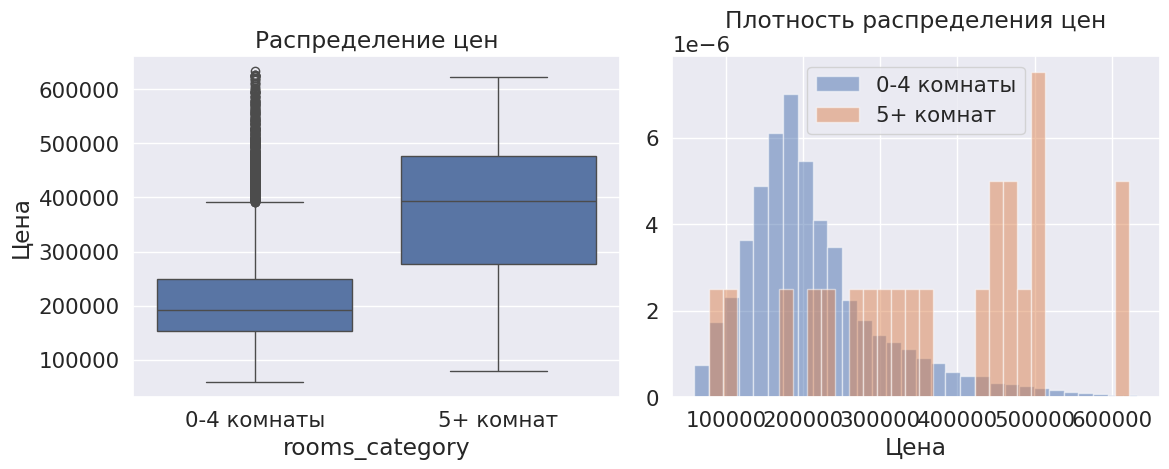

In [ ]:
df['rooms_category'] = np.where(df['Rooms'] >= 5, '5+ комнат', '0-4 комнаты')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x='rooms_category', y='Price', data=df, ax=axes[0])
axes[0].set_title('Распределение цен')
axes[0].set_ylabel('Цена')
axes[0].ticklabel_format(style='plain', axis='y')

for category in df['rooms_category'].unique():
    subset = df[df['rooms_category'] == category]
    axes[1].hist(subset['Price'], bins=30, alpha=0.5, label=category, density=True)

axes[1].set_title('Плотность распределения цен')
axes[1].set_xlabel('Цена')
axes[1].legend()
axes[1].ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

Распределения цен с квартирами до 5 комнат и с 5 и более комнатами отличаются. Оставим квартиры от 1 до 5 комнат в датасете, остальные – удалим, так как они представляют очень малую часть данных и, вероятно, являются строками, занесенными с ошибками.

In [ ]:
df = df[~((df['Rooms'] == 0) | (df['Rooms'] > 5))]

In [ ]:
df.drop('rooms_category', axis=1, inplace=True)

### Square

Ограничим диапазон значений 10 и 300.

In [ ]:
df = df[~((df['Square'] < 10) | (df['Square'] > 300))]

### Price

Выведем график распределения целевой переменной.

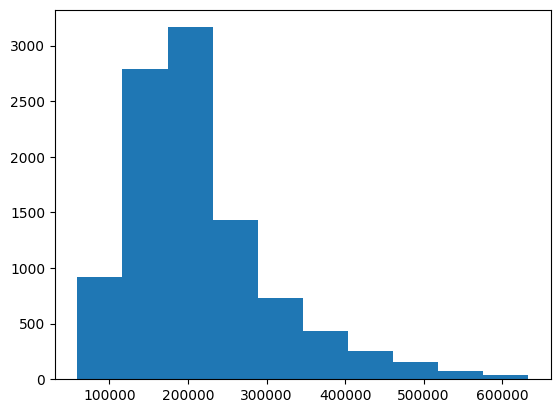

In [ ]:
plt.hist(df['Price'])
plt.show()

Видим распределение с правым сдвигом.

In [ ]:
df['Price'].skew()

np.float64(1.3674598161141966)

Коэффициент асимметрии больше 1, что подтверждает правостороннюю асимметрию.

In [ ]:
df['Price'].kurtosis()

np.float64(2.2491066576807714)

Умеренный эксцесс (1-3) типичен для цен на недвижимость.

По графику и статистикам видим, что распределение больше является правосторонним, чем нормальным. Учтем это при обучении.


## Обработка пропусков

In [ ]:
df.isna().sum() *100 / len(df)

,0
DistrictId,0.000000
Rooms,0.000000
Square,0.000000
LifeSquare,21.125350
KitchenSquare,0.000000
Floor,0.000000
HouseFloor,0.000000
HouseYear,0.000000
Ecology_1,0.000000
Ecology_2,0.000000


Почти половина значений в колонке 'Healthcare_1' являются пропущенными. Также по матрице корреляций этот признак почти не коррелирует с целевой переменной.  Поэтому будет логично удалить этот признак.

In [ ]:
df.drop('Healthcare_1', axis=1, inplace=True)

Четвертая часть значений 'LifeSquare' являются пропусками. Заполним их исходя из общей площади и жилой площади.

In [ ]:
df.loc[(df['LifeSquare'].isnull()), 'LifeSquare'] = (df['Square'] - df['KitchenSquare']) - 2

Проверим отсутствие пропусков.

In [ ]:
df.isna().sum()

,0
DistrictId,0
Rooms,0
Square,0
LifeSquare,0
KitchenSquare,0
Floor,0
HouseFloor,0
HouseYear,0
Ecology_1,0
Ecology_2,0


Пропусков нет.

# Разбиение на train и test

Разобьем данные на тренировочные и тестовые.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Price', axis=1), df['Price'], test_size=0.33, shuffle=True, random_state=42)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6682 entries, 8687 to 7286
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   DistrictId          6682 non-null   int64   
 1   Rooms               6682 non-null   float64 
 2   Square              6682 non-null   float64 
 3   LifeSquare          6682 non-null   float64 
 4   KitchenSquare       6682 non-null   float64 
 5   Floor               6682 non-null   int64   
 6   HouseFloor          6682 non-null   float64 
 7   HouseYear           6682 non-null   int64   
 8   Ecology_1           6682 non-null   float64 
 9   Ecology_2           6682 non-null   object  
 10  Ecology_3           6682 non-null   object  
 11  Social_1            6682 non-null   int64   
 12  Social_2            6682 non-null   int64   
 13  Social_3            6682 non-null   int64   
 14  Helthcare_2         6682 non-null   category
 15  Shops_1             6682 non-null   int6

Создадим списки категориальных и вещественных признаков.

In [ ]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

Построим несколько базовых моделей, чтобы понять, какая из них может лучше подойти к данным.

# Обучение и оптимизация моделей

## LinearRegression

Для начала построим базовую модель линейной регрессии. Перед обучением модели необходимо выполнить преобразование признаков.

Закодируем категориальные признаки при помощи OneHotEncoder.

In [ ]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
train_cat = encoder.fit_transform(X_train[cat_cols])

Стандартизируем количественные признаки.

In [ ]:
scaler = StandardScaler()
train_num = scaler.fit_transform(X_train[num_cols])

Соединим вместе стандартизированные количественные признаки и закодированные категориальные признаки.

In [ ]:
X_train = np.hstack([train_num, train_cat])
X_train.shape

(6682, 26)

Преобразуем признаки для тестовых данных с помощью метода transform обученных ранее encoder и scaler.

In [ ]:
test_cat = encoder.transform(X_test[cat_cols])
test_num = scaler.transform(X_test[num_cols])

In [ ]:
X_test = np.hstack([test_num, test_cat])
X_test.shape

(3292, 26)

Для улучшения работы модели, необходимо преобразовать и целевую переменную. Ранее был сделан вывод, что целевая переменная имеет ненормальное распределение, значения цен строго положительны. Для максимально возможного приближения данных к нормальному распределению применим к целевой переменной преобразование Бокса-Кокса – это мощный статистический метод, который адаптируется под данные и обеспечивает хорошее соответствие нормальному распределению.

In [ ]:
y_train_transform, optimal_lambda = stats.boxcox(y_train)

Проверим распределение.

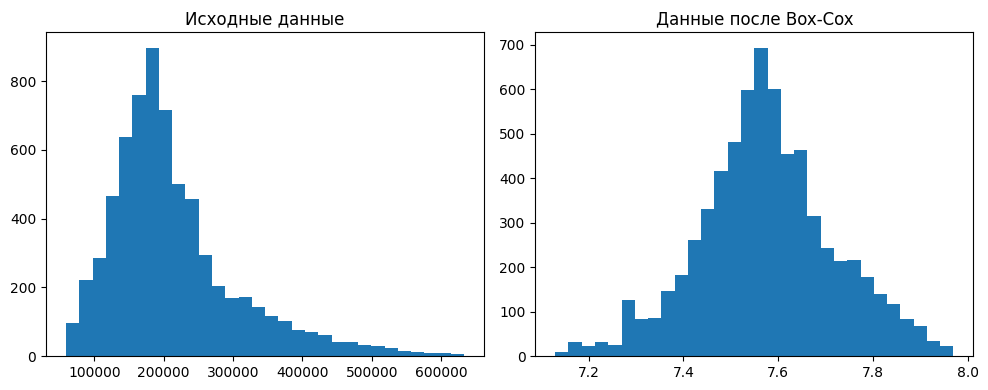

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30)
plt.title('Исходные данные')

plt.subplot(1, 2, 2)
plt.hist(y_train_transform, bins=30)
plt.title('Данные после Box-Cox')
plt.tight_layout()
plt.show()

Данные стали приближены к нормальному распределению.

Применим optimal_lambda к тестовым данным.

In [ ]:
y_test_transform = stats.boxcox(y_test, lmbda=optimal_lambda)

Построим базовую модель линейной регрессии.

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train_transform)

LinearRegression()

Выполним предсказания. Рассчитаем коэффициент детерминации  $r^2$, чтобы вычислить относительную оценку изменчивости целевой переменной, которую модель смогла объяснить. Будем использовать $r^2$ для сравнения моделей.

Train R2:	0.525
Test R2:	0.545


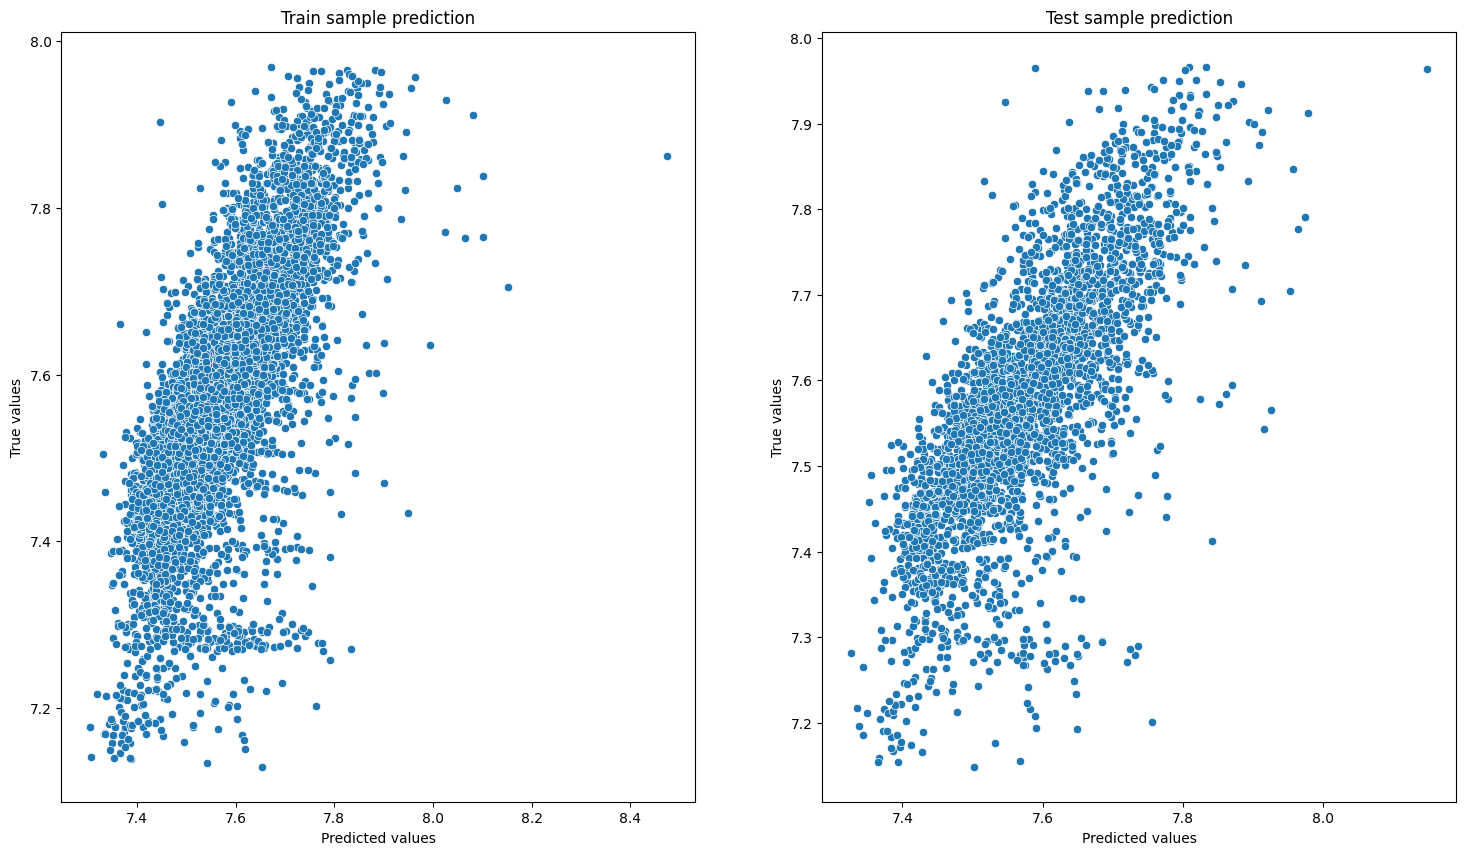

In [ ]:
y_train_preds = lr.predict(X_train)
y_test_preds = lr.predict(X_test)

evaluate_preds(y_train_transform, y_train_preds, y_test_transform, y_test_preds)

Коэффициент детерминации достаточно низкий, на графике видим, что предсказания не всегда точные.

Построим график остатков, чтобы понять ошибки модели.

In [ ]:
residuals = y_test_transform - y_test_preds

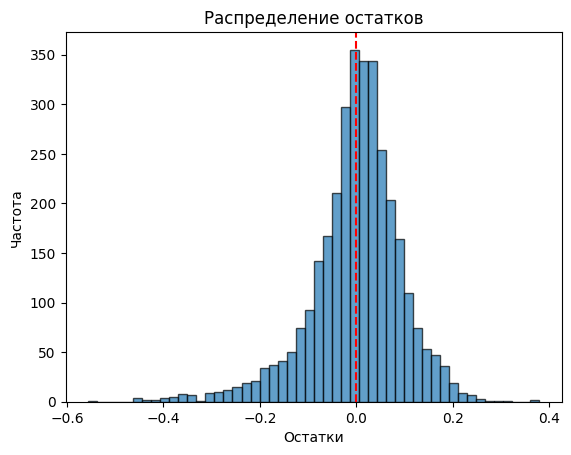

In [ ]:
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Распределение остатков')
plt.show()

Видим, что распределение близко к нормальному, но не является полностью симметричным.

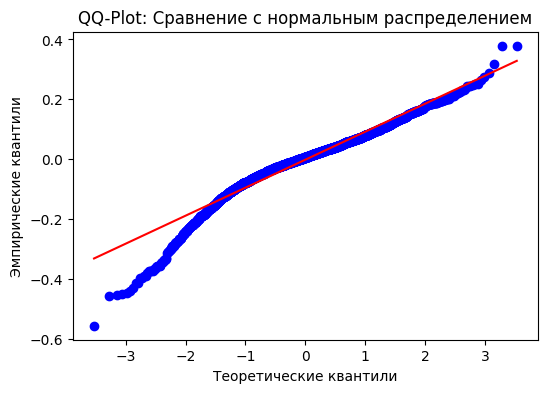

In [ ]:
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.xlabel("Теоретические квантили")
plt.ylabel("Эмпирические квантили")
plt.title("QQ-Plot: Сравнение с нормальным распределением")
plt.show()

На qq-графике видим внизу отклонение от нормальности.

## GammaRegressor

Попробуем использовать модель гамма-регрессии, так как, вероятно, она может больше подойти нашим данным: целевая переменная имеет правостороннюю асимметрию. Гамма-регрессия может автоматически учитывать асимметрию и меняющуюся дисперсию данных, что делает результаты статистически более корректными и точными, чем при использовании обычной линейной регрессии даже после преобразования целевой переменной. Поэтому при создании модели не будем преобразовывать стоимость квартир – возьмем значения, представленные в датасете.

In [ ]:
gm = GammaRegressor(alpha=0)
gm.fit(X_train, y_train)

GammaRegressor(alpha=0)

Train R2:	0.345
Test R2:	0.529


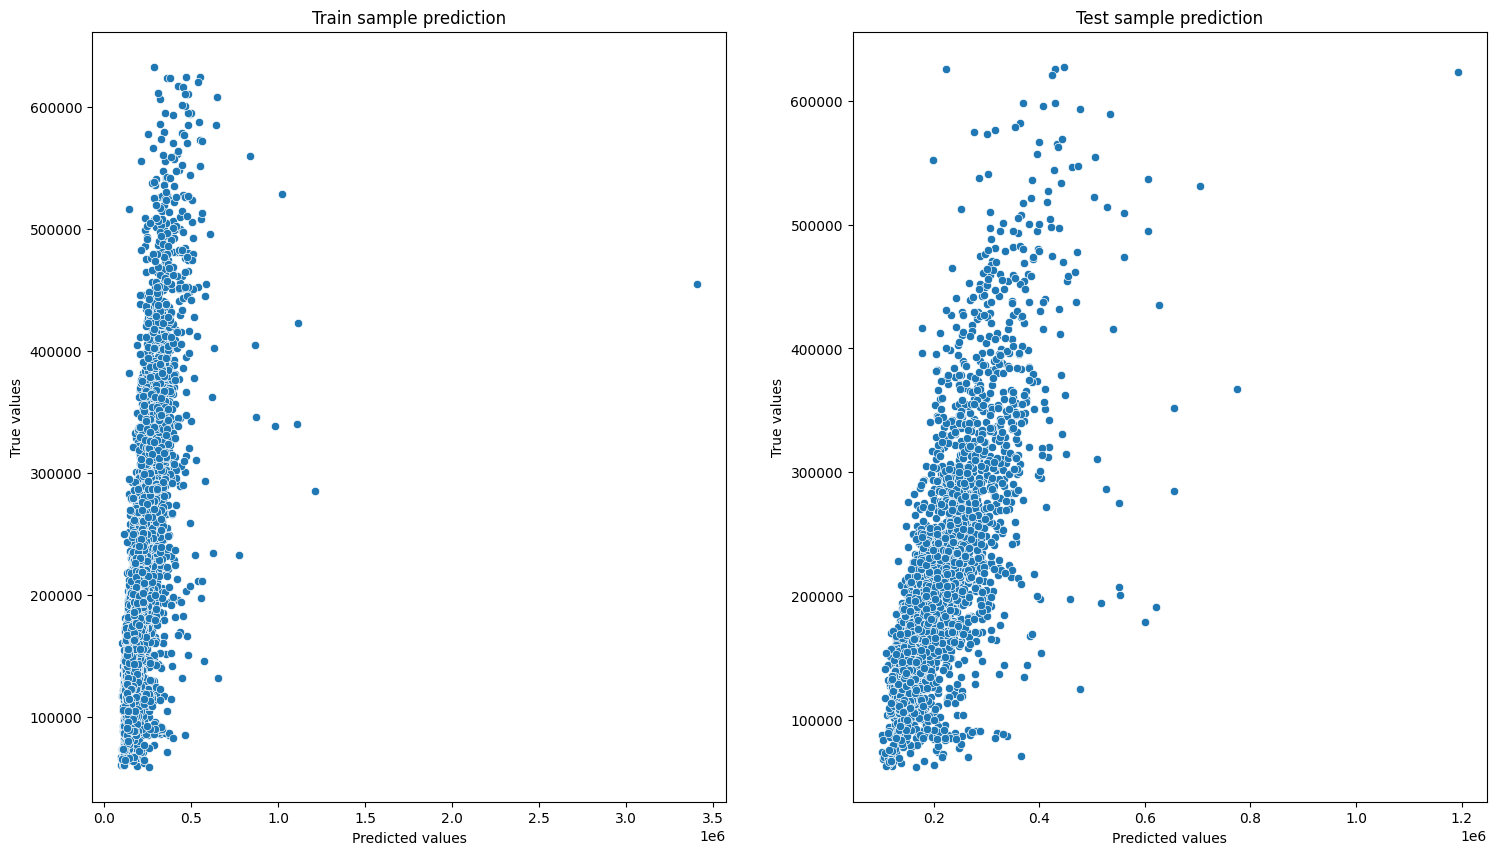

In [ ]:
y_train_preds = gm.predict(X_train)
y_test_preds = gm.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Коэффициент детерминации  $r^2$ на тренировочных данных сильно снизился. На тестовых данных он снизился незначительно.

Построим график остатков, чтобы понять ошибки модели.

In [ ]:
residuals = y_test - y_test_preds

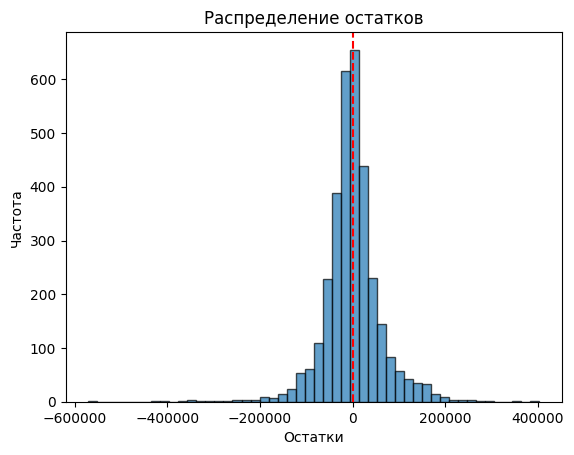

In [ ]:
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Распределение остатков')
plt.show()

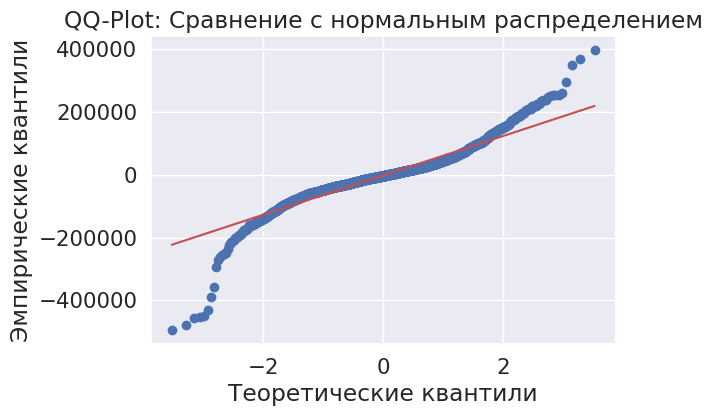

In [ ]:
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.xlabel("Теоретические квантили")
plt.ylabel("Эмпирические квантили")
plt.title("QQ-Plot: Сравнение с нормальным распределением")
plt.show()

Распределение остатков близко к нормальному, значит модель статистически корректна. Возможно, признаки имеют низкую предсказательную способность или модель слишком проста для данных.

## RandomForestRegressor

Попробуем один из более сложных алгоритмов – RandomForestRegressor. Вероятно, он сможет выявить и обработать нелинейные зависимости и взаимодействия признаков, что повысит качество предсказаний.

In [ ]:
rf = RandomForestRegressor(random_state=21)
rf.fit(X_train, y_train_transform)

RandomForestRegressor(random_state=21)

Train R2:	0.956
Test R2:	0.704


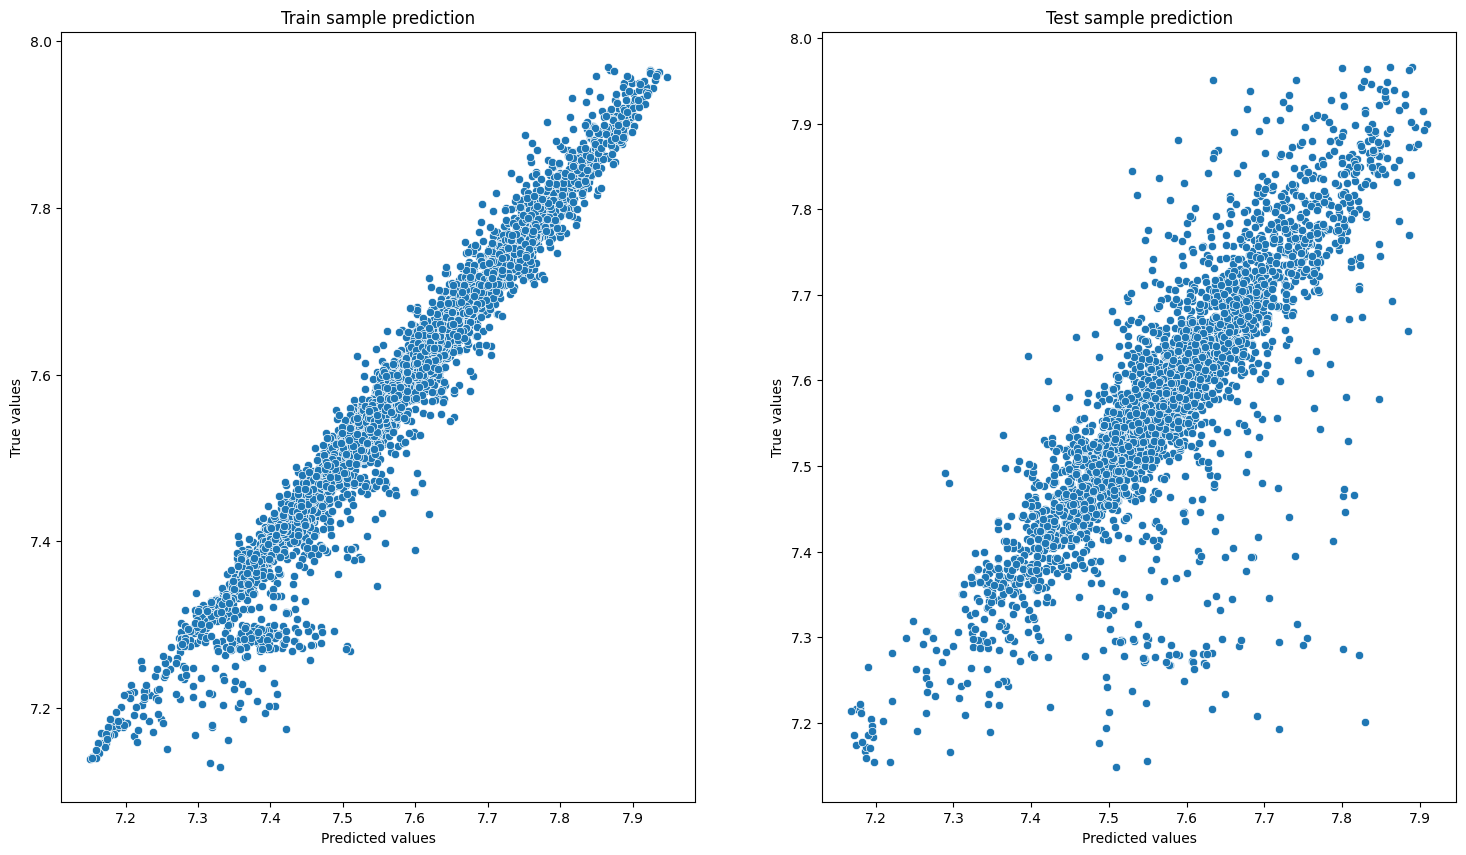

In [ ]:
y_train_preds = rf.predict(X_train)
y_test_preds = rf.predict(X_test)

evaluate_preds(y_train_transform, y_train_preds, y_test_transform, y_test_preds)

Коэффициент детерминации значительно увеличился на тренировочных данных. На тестовых данных $r^2$ увеличился, но не настолько сильно. Алгоритм переобучается.

## LGBMRegressor

Попробуем использовать другой древовидный алгоритм – LGBMRegressor. Он может хорошо подойти для данной задачи, потому что он использует градиентный бустинг, обеспечивая высокую точность и скорость обучения.

In [ ]:
lgb = LGBMRegressor(random_state=42)
lgb.fit(X_train, y_train_transform)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6682, number of used features: 26
[LightGBM] [Info] Start training from score 7.574568


LGBMRegressor(random_state=42)

Train R2:	0.829
Test R2:	0.721


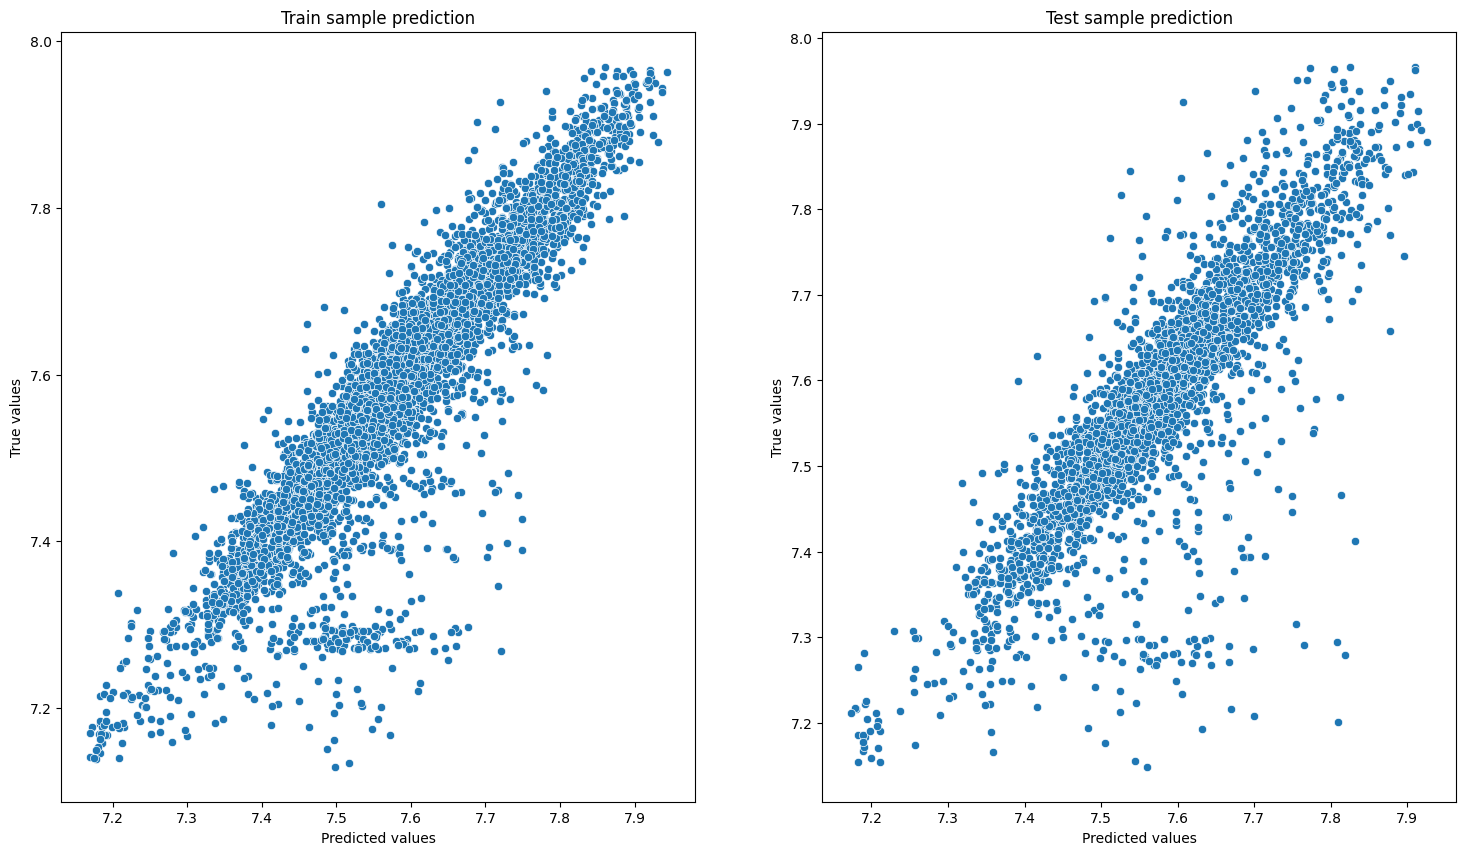

In [ ]:
y_train_preds = lgb.predict(X_train)
y_test_preds = lgb.predict(X_test)

evaluate_preds(y_train_transform, y_train_preds, y_test_transform, y_test_preds)

Коэффициент детерминации по сравнению с RandomForestRegressor  снизился на тренировочных данных, но немного увеличился на тестовых – переобучение не такое сильное.

## CatBoostRegressor

Также попробуем использовать CatBoostRegressor, потому что показывает стабильную производительность на разнородных признаках благодаря симметричным деревьям и эффективной реализации градиентного бустинга. Для него не требуется кодирование категориальных признаков. Признак 'DistrictId' передадим в модель как категориальный.

In [ ]:
cat_cols = ['DistrictId'] + X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['float64', 'int64']).drop(['DistrictId'], axis=1).columns.tolist()

In [ ]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
cb = CatBoostRegressor(random_state=42, cat_features=cat_cols)
cb.fit(X_train, y_train_transform)

Learning rate set to 0.055273
0:	learn: 0.1400586	total: 19.8ms	remaining: 19.8s
1:	learn: 0.1363311	total: 39.1ms	remaining: 19.5s
2:	learn: 0.1330756	total: 49.3ms	remaining: 16.4s
3:	learn: 0.1299268	total: 60.3ms	remaining: 15s
4:	learn: 0.1271251	total: 70.8ms	remaining: 14.1s
5:	learn: 0.1244630	total: 78.9ms	remaining: 13.1s
6:	learn: 0.1220972	total: 87.9ms	remaining: 12.5s
7:	learn: 0.1197519	total: 96.9ms	remaining: 12s
8:	learn: 0.1176372	total: 106ms	remaining: 11.7s
9:	learn: 0.1152781	total: 116ms	remaining: 11.5s
10:	learn: 0.1132601	total: 128ms	remaining: 11.5s
11:	learn: 0.1113614	total: 137ms	remaining: 11.3s
12:	learn: 0.1095677	total: 146ms	remaining: 11.1s
13:	learn: 0.1078992	total: 155ms	remaining: 10.9s
14:	learn: 0.1062175	total: 164ms	remaining: 10.7s
15:	learn: 0.1045424	total: 172ms	remaining: 10.6s
16:	learn: 0.1031811	total: 180ms	remaining: 10.4s
17:	learn: 0.1018727	total: 189ms	remaining: 10.3s
18:	learn: 0.1006181	total: 203ms	remaining: 10.5s
19:	lea

Train R2:	0.817
Test R2:	0.728


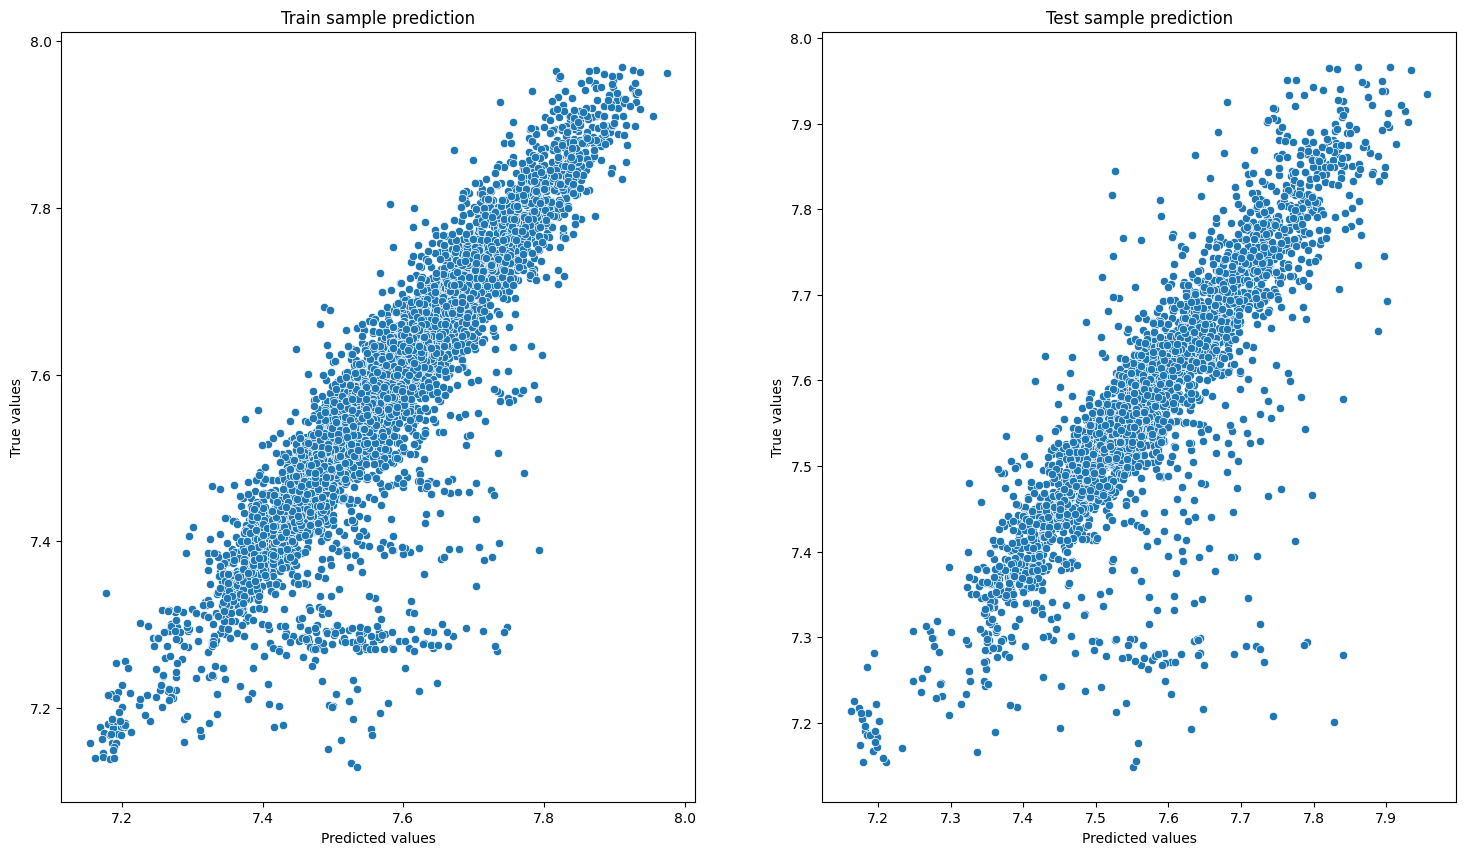

In [ ]:
y_train_preds = cb.predict(X_train)
y_test_preds = cb.predict(X_test)

evaluate_preds(y_train_transform, y_train_preds, y_test_transform, y_test_preds)

CatBoostRegressor показал лучшее значение метрики $r^2$ на тренировочных данных по сравнению с другими моделями. Если CatBoost показывает хорошее качество, а GammaRegressor — плохое, это означает, что ваши данные имеют сложные нелинейные зависимости и взаимодействия, которые tree-based модели улавливают лучше. Переобучение ниже по сравнению с моделями с коэффициентом детерминации RandomForestRegressor и LGBMRegressor. Для улучшения качества будем использовать CatBoostRegressor.


При помощи shap выделим признаки, которые приносят наибольшую пользу модели.

In [ ]:
explainer = shap.TreeExplainer(cb)

In [ ]:
shap_values = explainer.shap_values(X_test)

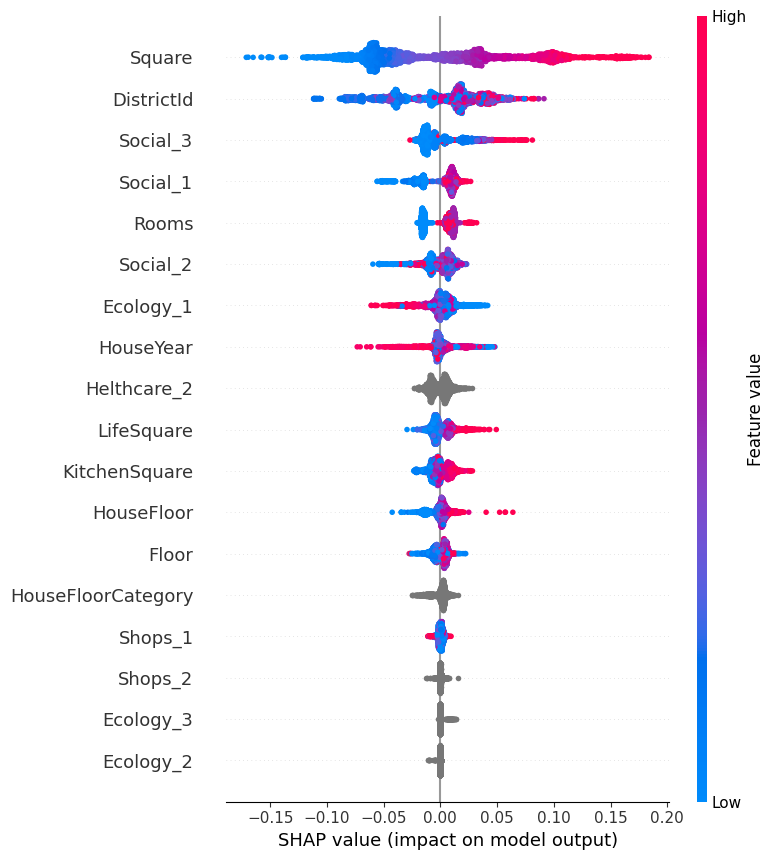

In [ ]:
if isinstance(X_test, np.ndarray):
    X_test_df = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])
else:
    X_test_df = X_test

shap.summary_plot(shap_values, X_test_df)

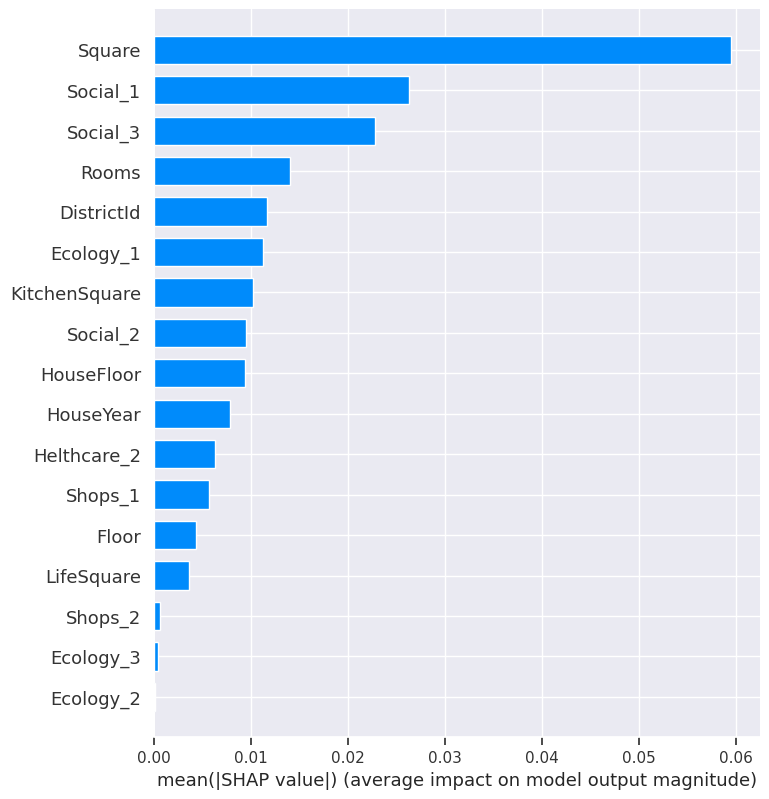

In [ ]:
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

Самыми информативными для модели оказались признаки Square, DistrictId, Social_3, Social_1, Rooms. Наименее информативными оказались признаки 'Shops_2', 'Ecology_3', 'Ecology_2'.

# Feature engineering и обучение лучшей модели

Далее было проведено несколько опытов по созданию и преобразованию признаков для улучшения предсказательной способности модели и повышения точности. Часть признаков добавлены в датафрейм до разбиения на тренировочный и тестовый датасеты, так как эти признаки основаны на информации отдельного наблюдения (например, отношение значения одного признака к другому) и не используют статистики всего датасета. Это не приведет к утечке информации из тестовой выборки.

Вычисление возраста дома,  преобразование года постройки, вычисление отношения жилой площади к площади не привели к повышению метрики. Удаление коррелирующих и малоинформативных признаков немного снизило качество обучения.




Объединим наработки в одну функцию.  

In [ ]:
def full_preprocessing(df):
  df_copy = df.copy()

  df_copy.drop(['Id', 'Healthcare_1'], axis=1, inplace=True)

  df_copy = df_copy[~((df_copy['Square'] < 10) | (df_copy['Square'] > 300))]

  ks = df_copy.loc[(df_copy['KitchenSquare'] >= df_copy['Square']), 'KitchenSquare']

  new_ks = []
  for k in ks:
    s = list(str(int(k)))
    s.insert(1, '.')
    n = ''.join(s)
    new_ks.append(int(float(n)))

  df_copy.loc[(df_copy['KitchenSquare'] >= df_copy['Square']), 'KitchenSquare'] = new_ks

  df_copy.loc[(df_copy['LifeSquare'] > df_copy['Square']), 'LifeSquare'] = df_copy['Square'] - df_copy['KitchenSquare']

  mask = df_copy['HouseFloor'] < df_copy['Floor']
  df_copy.loc[mask, ['Floor', 'HouseFloor']] = df_copy.loc[mask, ['HouseFloor', 'Floor']].values

  df_copy.loc[df_copy['HouseYear'] > 2020, 'HouseYear'] = 2020

  df_copy['HouseFloor'] = df_copy['HouseFloor'].clip(upper=50)
  df_copy['HouseFloorCategory'] = pd.cut(df_copy['HouseFloor'], bins=[0, 5, 9, 17, 25, 40, 100], labels=['1-5', '6-9', '10-17', '18-25', '26-40', '40+'])

  df_copy = df_copy[~((df_copy['Rooms'] == 0) | (df_copy['Rooms'] > 5))]

  df_copy.loc[(df_copy['LifeSquare'].isnull()), 'LifeSquare'] = (df_copy['Square'] - df_copy['KitchenSquare']) - 2

  df_copy['Area_ratio'] = df_copy['LifeSquare'] / df_copy['Square']
  df_copy['SquarePerRoom'] = df_copy['Square'] / df_copy['Rooms']
  df_copy['FloorRatio'] = df_copy['Floor'] / df_copy['HouseFloor']

  df_copy['Ecology_Social'] = df_copy['Ecology_1'] * df_copy['Social_1'] / (df_copy['Social_3'] + 1)
  df_copy['Room_Floor_Interaction'] = df_copy['Rooms'] * (df_copy['Floor'] / (df_copy['HouseFloor'] + 1))
  df_copy['District_Room_Price'] = df_copy['DistrictId'] * df_copy['Rooms'] / df_copy['Square']

  # current_year = datetime.now().year
  # df['House_age'] = current_year - df['HouseYear']

  # df['house_age_squared'] = df['HouseYear'] ** 2
  # df['log_house_age'] = np.log1p(df['HouseYear'])

  # df['SquarePerRoom'] = df['Square'] / df['Rooms']
  # df['FloorRatio'] = df['Floor'] / df['HouseFloor']
  # df['YearsOld'] = 2025 / df['HouseYear']

  return df_copy

In [ ]:
df = full_preprocessing(df)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.drop('Price', axis=1), df['Price'], test_size=0.2, shuffle=True, random_state=42)

После разбиения данных на тренировочные и тестовые, создан класс с дополнительными признаками, вычисленными только на обучающем наборе данных, чтобы избежать утечки данных из тестового набора в модель во время обучения, что искусственно завысит её качество.

Был добавлен признак популярности района, и позже удален признак района, так как это привело к улучшению метрики. Средняя цена по району, по количеству комнат, по площади привели к росту $r^2$.

In [ ]:
class Feature_engineering(BaseEstimator, TransformerMixin):

    def __init__(self, district_col='DistrictId', rooms_col='Rooms', square_col='Square'):
        self.district_col = district_col
        self.rooms_col = rooms_col
        self.square_col = square_col
        self.new_cols = None
        self.default_values = {}
        self.feature_names_out_ = None
        self.categorical_features_ = []
        self.numeric_features_ = []

    def fit(self, X, y=None):
        self.new_cols = {}

        # популярность района
        self.new_cols['size'] = X[self.district_col].value_counts()
        self.default_values['size'] = self.new_cols['size'].median()

        # средняя цена по району
        district_price = pd.DataFrame({self.district_col: X[self.district_col],'price': y})
        self.new_cols['avg_price_dist'] = district_price.groupby(self.district_col)['price'].mean()
        self.default_values['avg_price_dist'] = self.new_cols['avg_price_dist'].median()

        # средняя цена по количеству комнат
        rooms_price = pd.DataFrame({self.rooms_col: X[self.rooms_col],'price': y})
        self.new_cols['avg_price_rooms'] = rooms_price.groupby(self.rooms_col)['price'].mean()
        self.default_values['avg_price_rooms'] = self.new_cols['avg_price_rooms'].median()

        # средняя цена по площади
        price_to_square = y / X[self.square_col].clip(1)
        square_price = pd.DataFrame({self.district_col: X[self.district_col], 'price_to_square': price_to_square})
        self.new_cols['avg_price_square'] = square_price.groupby(self.district_col)['price_to_square'].mean()
        self.default_values['avg_price_square'] = self.new_cols['avg_price_square'].median()

        # доля района
        total_objects = len(X)
        self.new_cols['share'] = self.new_cols['size'] / total_objects
        self.default_values['share'] = self.new_cols['share'].median()

        return self

    def transform(self, X):
        X_copy = X.copy()

        # DistrictSize
        district_size_df = pd.DataFrame(self.new_cols['size'], columns=['DistrictSize'])
        district_size_df.index.name = self.district_col
        district_size_df.reset_index(inplace=True)
        X_copy = X_copy.merge(district_size_df, on=self.district_col, how='left')
        X_copy['DistrictSize'] = X_copy['DistrictSize'].fillna(self.default_values['size'])

        # DistrictShare
        district_share_df = pd.DataFrame(self.new_cols['share'], columns=['DistrictShare'])
        district_share_df.index.name = self.district_col
        district_share_df.reset_index(inplace=True)
        X_copy = X_copy.merge(district_share_df, on=self.district_col, how='left')
        X_copy['DistrictShare'] = X_copy['DistrictShare'].fillna(self.default_values['share'])

        # DistrictAvgPrice
        district_price_df = pd.DataFrame(self.new_cols['avg_price_dist'], columns=['DistrictAvgPrice'])
        district_price_df.index.name = self.district_col
        district_price_df.reset_index(inplace=True)
        X_copy = X_copy.merge(district_price_df, on=self.district_col, how='left')
        X_copy['DistrictAvgPrice'] = X_copy['DistrictAvgPrice'].fillna(self.default_values['avg_price_dist'])

        # RoomsAvgPrice
        rooms_price_df = pd.DataFrame(self.new_cols['avg_price_rooms'], columns=['RoomsAvgPrice'])
        rooms_price_df.index.name = self.rooms_col
        rooms_price_df.reset_index(inplace=True)
        X_copy = X_copy.merge(rooms_price_df, on=self.rooms_col, how='left')
        X_copy['RoomsAvgPrice'] = X_copy['RoomsAvgPrice'].fillna(self.default_values['avg_price_rooms'])

        # SquareAvgPrice
        square_price_df = pd.DataFrame(self.new_cols['avg_price_square'], columns=['SquareAvgPrice'])
        square_price_df.index.name = self.district_col
        square_price_df.reset_index(inplace=True)
        X_copy = X_copy.merge(square_price_df, on=self.district_col, how='left')
        X_copy['SquareAvgPrice'] = X_copy['SquareAvgPrice'].fillna(self.default_values['avg_price_square'])

        X_copy = X_copy.drop(columns=[self.district_col], axis=1)
        self.feature_names_out_ = X_copy.columns.tolist()
        self.numeric_features_ = X_copy.select_dtypes(include=['int', 'float']).columns.tolist()
        self.categorical_features_ = X_copy.select_dtypes(include=['object', 'category']).columns.tolist()

        return X_copy

    def get_feature_names_out(self):
        return self.feature_names_out_

    def get_numeric_features(self):
        return self.numeric_features_

    def get_categorical_features(self):
        return self.categorical_features_

        return X_copy

Создадим класс FeatureSelector для выбора необходимых столбцов.

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

Проверим работу класса Feature_engineering и получим категориальные и числовые столбцы для финального pipeline.

In [ ]:
feat_eng = Feature_engineering()
feat_eng.fit(X_train, y_train)
d = feat_eng.transform(X_train)

In [ ]:
num_cols = feat_eng.get_numeric_features()
cat_cols = feat_eng.get_categorical_features()

Создадим трансформеры, которые будут выбирать категориальные столбцы, числовые столбцы и стандартизировать их.

In [ ]:
cat_transformer = Pipeline([
    ('cat_selector', FeatureSelector(column=cat_cols))
])

cat_indices = [0, 1, 2, 3]

num_transformer = Pipeline([
    ('num_selector', FeatureSelector(column=num_cols)),
    ('scaler', StandardScaler())
])

In [ ]:
preprocessor = ColumnTransformer([
    ('cat', cat_transformer, cat_cols),
    ('num', num_transformer, num_cols)
    ])

Создадим модель CatBoostRegressor, передав ей категориальные признаки.

In [ ]:
catboost_model = CatBoostRegressor(cat_features=cat_indices, random_state=42)

Создадим pipeline, который будет добавлять новые столбцы в данные, предобрабатывать их и передавать в модель.

In [ ]:
full_pipeline = Pipeline(steps=[
    ('transformations', Feature_engineering()),
    ('preprocessor', preprocessor),
    ('regressor', catboost_model)
])

Будем использовать кросс-валидацию для оценки того, насколько стабильно и хорошо модель будет работать на новых данных.

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    full_pipeline,
    X_train,
    y_train,
    cv=kf,
    scoring='r2'
)

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 0.1273864	total: 31.2ms	remaining: 6.2s
5:	learn: 0.1243347	total: 36.6ms	remaining: 6.06s
6:	learn: 0.1217492	total: 42.3ms	remaining: 6s
7:	learn: 0.1192730	total: 47.7ms	remaining: 5.91s
8:	learn: 0.1168755	total: 53.1ms	remaining: 5.85s
9:	learn: 0.1147454	total: 58.4ms	remaining: 5.78s
10:	learn: 0.1127653	total: 63.8ms	remaining: 5.73s
11:	learn: 0.1108038	total: 69ms	remaining: 5.68s
12:	learn: 0.1093215	total: 74.1ms	remaining: 5.63s
13:	learn: 0.1076385	total: 79.1ms	remaining: 5.57s
14:	learn: 0.1060413	total: 84.2ms	remaining: 5.53s
15:	learn: 0.1044703	total: 89.2ms	remaining: 5.49s
16:	learn: 0.1029216	total: 94.6ms	remaining: 5.47s
17:	learn: 0.1017512	total: 99.7ms	remaining: 5.44s
18:	learn: 0.1006563	total: 105ms	remaining: 5.4s
19:	learn: 0.0994797	total: 110ms	remaining: 5.38s
20:	learn: 0.0985331	total: 115ms	remaining: 5.36s
21:	learn: 0.0974595	total: 120ms	remaining: 5.35s
22:	learn: 0.

In [ ]:
print(f"r2 на фолдах: {cv_scores}")
print(f"Средний r2: {cv_scores.mean():.4f}")
print(f"Стандартное отклонение: {cv_scores.std():.4f}")

r2 на фолдах: [0.71680872 0.71989239 0.74495325 0.79707599 0.78129583]
Средний r2: 0.7520
Стандартное отклонение: 0.0323


Значения $r^2$ находятся в диапазоне от $0.717$ до $0.797$, средний $r^2=0.752$. Отклонение метрики от среднего значения составляет менее 5%, это значит, что модель работает стабильно и не зависит от конкретного разбиения данных.  

Выполним предсказание для тестовых данных.

In [ ]:
# full_pipeline.fit(X_train, y_train)
y_test_pred = full_pipeline.predict(X_test)

In [ ]:
r2(y_test, y_test_pred)

0.7567968884495596

Полученное значение $r^2$ является самым высоким. Изобразим графически.

Train R2:	0.909
Test R2:	0.757


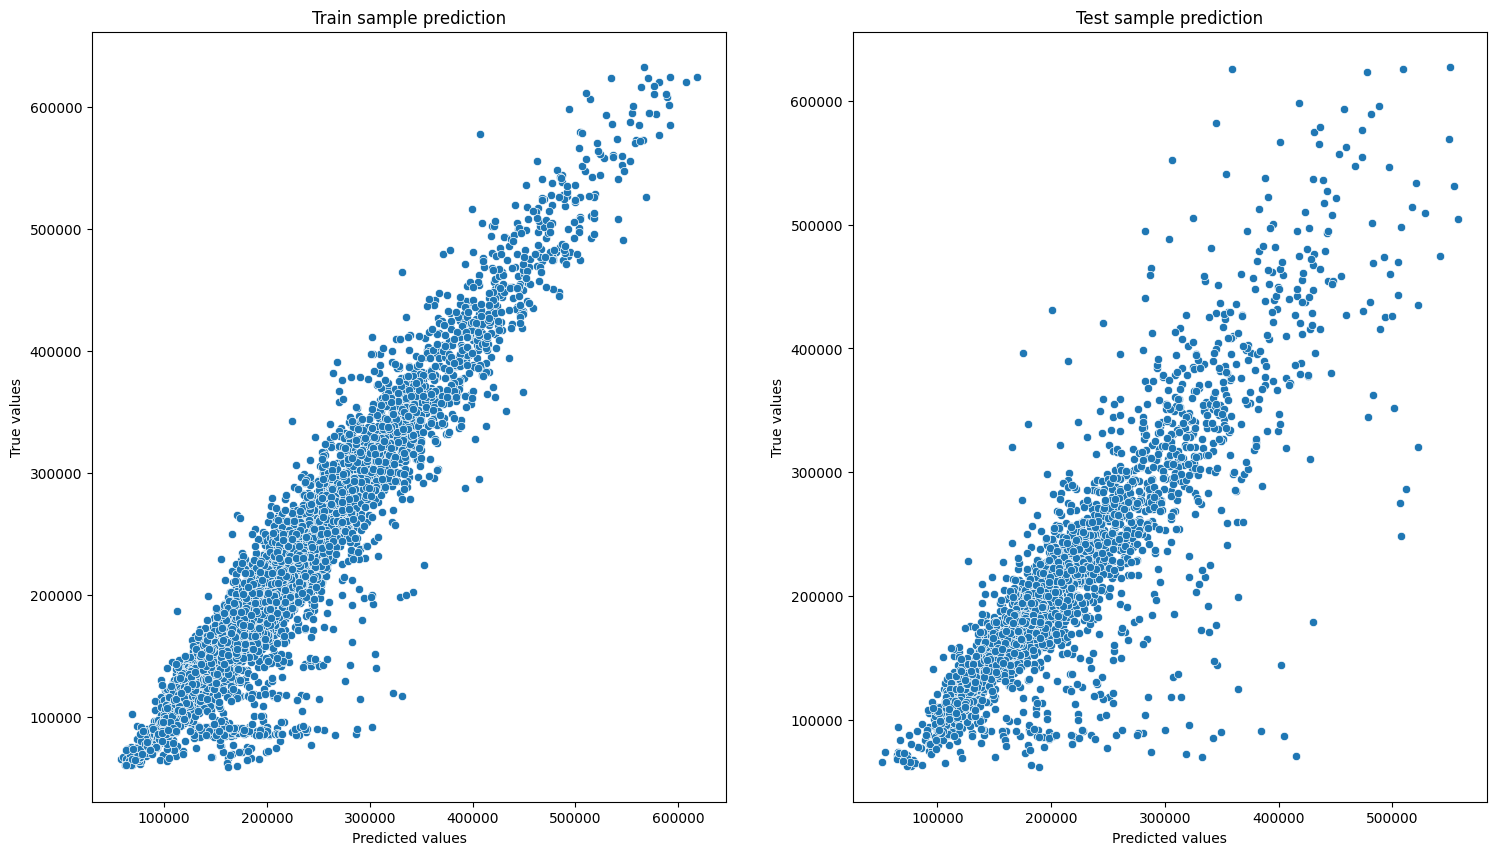

In [ ]:
y_train_preds = full_pipeline.predict(X_train)
y_test_preds = full_pipeline.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

На тестовой выборке получено значение $r^2=0.757$, что выше всех предыдущих значений метрики.

# Вывод

В процессе исследования было выполнено следующее:
- Проведен разведочный анализ данных, в ходе которого были выявлены проблемы:
  - наличие пропусков;
  - наличие ошибочных данных и выбросов.

  Был удален признак 'Id', так как он не вносит полезной информации для прогнозирования, но может привести к переобучению модели. Также был удален признак 'Healthcare_1' из-за большого количества пропусков. Были устранены несоответствия значений между столбцами, когда этаж квартиры больше количества этажей в здании, или площадь кухни больше общей площади. Слишком большие и маленькие значения признаков были ограничены исходя из логики данных.
- Были реализованы и оценены следующие базовые алгоритмы:
  - LinearRegression.
  - GammaRegressor.
  - RandomForestRegressor.
  - LGBMRegressor.
  - CatBoostRegressor.

  Линейная и гамма-регрессия показали низкие результаты на тренировочных и тестовых данных. RandomForestRegressor показал очень хороший результат на тренировочных данных ($r^2=0.956$), но гораздо более плохой на тестовых ($r^2=0.704$),  что означает переобучение модели. LGBMRegressor переобучился меньше: $r^2=0.829$ и $r^2=0.721$ на тренировочных и тестовых данных соответственно.  Наилучший результат показала модель CatBoostRegressor со значением $r^2=0.817$ и $r^2=0.728$ на тренировочных и тестовых данных соответственно. Также CatBoostRegressor оказался менее склонен к переобучению, и был выбран для дальнейшего улучшения.
- Осуществлена генерация новых признаков для улучшения предсказательной способности модели и повышения точности. Часть признаков добавлены в датафрейм до разбиения на тренировочный и тестовый датасеты, так как эти признаки основаны на информации отдельного наблюдения (например, отношение значения одного признака к другому) и не используют статистики всего датасета. Часть признаков были сконструированы на тренировочных данных и применены к тестовому набору, чтобы модель успешно работала на реальных данных и имела высокую обобщающую способность, то есть показывала  хорошее качество на новых примерах. Для дополнительной проверки качества использовалась кросс-валидация, в ходе которой получено среднее значение $r^2=0.752$.


Итоговая модель имеет значение $r^2=0.757$ на тестовых данных.
